# Intro Chatbot with Search using LangGraph

In [22]:
import os
import getpass

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [23]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model

In [24]:
# state where we can add messages as we update the state
graph_builder = StateGraph(MessagesState)

In [25]:
llm = init_chat_model("openai:gpt-4.1")

web_search_tool = TavilySearch(max_results=2)
tools = [web_search_tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [26]:
from typing import Literal
from langgraph.graph import END
# Tools condition implements this under the hood
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [27]:
tool_node = ToolNode(tools=tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    should_continue
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

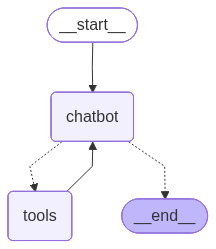

In [28]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [29]:
graph.invoke({"messages": ["IN the latest langgraph langchain announcement for their 1.0.0 version what did they said about langchain and langgraph engineering relationship? WHo now is built on top of who?"]})

{'messages': [HumanMessage(content='IN the latest langgraph langchain announcement for their 1.0.0 version what did they said about langchain and langgraph engineering relationship? WHo now is built on top of who?', additional_kwargs={}, response_metadata={}, id='1994fb3f-9572-48c6-84bf-5f92a4116403'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_J7It7oDqyhnhCQK2OA1J3bqG', 'function': {'arguments': '{"query":"LangGraph 1.0.0 announcement langchain relationship engineering built on top","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1227, 'total_tokens': 1263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_8b22347a3e', 'i

# To add Memory to our chatbot with web search

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [31]:
graph = graph_builder.compile(checkpointer=memory)

In [32]:
# pick a thread to use as the key for the conversation
config = {"configurable": {"thread_id": "1"}}

In [33]:
user_input = "Sup my name is Lucas"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Sup my name is Lucas
================================== Ai Message ==================================

Hey Lucas! How’s it going? What can I help you with today?


In [34]:
user_input = "What is my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Lucas!


In [35]:
user_input = 'My favorite book is The Great Gatsby'
graph.invoke(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
)

{'messages': [HumanMessage(content='Sup my name is Lucas', additional_kwargs={}, response_metadata={}, id='46bdfdb1-cd92-407c-b71f-3e8cb60df4cd'),
  AIMessage(content='Hey Lucas! How’s it going? What can I help you with today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1192, 'total_tokens': 1209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_8b22347a3e', 'id': 'chatcmpl-D7gp7MsXJEKSMkmKoQ78KgtSeImR4', 'finish_reason': 'stop', 'logprobs': None}, id='run-f3db6a41-9b07-4547-9346-96e7a1d0b9aa-0', usage_metadata={'input_tokens': 1192, 'output_tokens': 17, 'total_tokens': 1209, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(c

In [36]:
user_input = "Search online for the latest edition of my favorite book"

graph.invoke(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
)

{'messages': [HumanMessage(content='Sup my name is Lucas', additional_kwargs={}, response_metadata={}, id='46bdfdb1-cd92-407c-b71f-3e8cb60df4cd'),
  AIMessage(content='Hey Lucas! How’s it going? What can I help you with today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1192, 'total_tokens': 1209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_8b22347a3e', 'id': 'chatcmpl-D7gp7MsXJEKSMkmKoQ78KgtSeImR4', 'finish_reason': 'stop', 'logprobs': None}, id='run-f3db6a41-9b07-4547-9346-96e7a1d0b9aa-0', usage_metadata={'input_tokens': 1192, 'output_tokens': 17, 'total_tokens': 1209, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(c